# Import Necessary Library

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import CuDNNLSTM
import matplotlib.pyplot as plt
from scaler import LogReturnScaler

tf.debugging.set_log_device_placement(False) # for debugging

# Step 1: Download and Preprocess Data

In [2]:
def download_data(ticker, start_date=None, end_date=None):
    data = yf.download(ticker, start=start_date, end=end_date)
    data_drop_level = data.droplevel(1, axis=1)
    data_round = data_drop_level.round(6)
    return data_round

# def normalize_data(data, standardize=True):
#     """
#     - Normalize the data by taking the log return of the closing price.
#     - Scale the log returns using the LogReturnScaler.
#     """
#     scaler = LogReturnScaler(standardize=standardize)
#     data_scaled = scaler.fit_transform(data)
#     return data_scaled, scaler

# def normalize_data(data, standardize=True):
#     data_log = np.log(data)
#     if standardize:
#         data_scaled = (data_log - data_log.mean()) / data_log.std()
#     else:
#         data_scaled = data_log
#     scaler = None
#     return data_scaled, scaler

# def normalize_data(data, standardize=True):
#     iqr = np.subtract(*np.percentile(data, [75, 25]))
#     data_scaled = (data - np.median(data)) / iqr
#     return data_scaled, None

# def normalize_data(data, standardize=True):
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
#     return data_scaled, scaler

def normalize_data(data, standardize=True):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    return data_scaled, scaler

# def normalize_data(data, standardize=True):
#     return data, None


def create_windows(data, window_size, horizon=1):
    """
    Split time-series data into input windows and target windows.
    - data: 1D array of transformed log returns.
    - window_size: Number of past time steps to use as input.
    - horizon: Number of future time steps to predict.
    """
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+horizon])
    X, y = np.array(X), np.array(y)
    return X, y

# Define function for Fitting Quality

In [3]:
def calculate_volatility(data, window=20):
    """"
    The volatility is calculated as the median of the rolling standard deviation of the closing prices.
    """
    if isinstance(data, pd.Series):
        data = data['Close']
    df = pd.Series(data)
    volatility = df.rolling(window=window).std()
    volatility_median = volatility.median() 
    standardized_volatility_median = volatility_median / df.median()
    return standardized_volatility_median

def calculate_baseline_loss(X_train, y_train):
    """
    Calculate the baseline loss using the last observed value as the prediction.
    """
    y_train_pred = X_train[:, -1]  # Use the last observed value as the prediction
    baseline_loss = mean_squared_error(y_train, y_train_pred)
    return baseline_loss

def fitting_multiplier(data_volatility, baseline_volatility, alpha=0.8, beta=1.2):
    """
    Calculate underfitting and overfitting multipliers based on volatility.
    - alpha: Underfitting multiplier (default: 0.8).
    - beta: Overfitting multiplier (default: 1.2).
    """
    ratio = data_volatility / baseline_volatility
    underfit_multiplier = alpha * ratio
    overfit_multiplier = beta * ratio
    return underfit_multiplier, overfit_multiplier

def fitting_threshold(train_loss, baseline_loss, underfit_multiplier, overfit_multiplier):
    """"
    Calculate underfitting and overfitting thresholds based on training and baseline losses.

    """
    underfit_threshold = baseline_loss * underfit_multiplier
    overfit_threshold = train_loss * overfit_multiplier
    return underfit_threshold, overfit_threshold

def check_fitting(train_loss, val_loss, underfit_threshold, overfit_threshold):
    """
    Check for underfitting and overfitting based on dynamic thresholds.
    
    """
    if train_loss > underfit_threshold:
        return "underfitting"
    elif val_loss > overfit_threshold:
        return "overfitting"
    else:
        return "well-fitted"

# Step 2: Define LSTM Model

In [4]:
def build_lstm_aro_model(input_shape, x0, x1, x2, x3, x4, x5, x6, optimizer, learning_rate):
    print("below is the input shape and hyperparameters for the model")
    # Print the input shape
    print(f'input shape: ', input_shape)
    # Print the hyperparameters
    print(f"hyperparameters: {'{'}'x0': {x0}, 'x1': {x1}, 'x2': {x2}, 'x3': {x3}, 'x4': {x4}, 'x5': {x5}, 'x6': {x6}, 'optimizer': '{optimizer}', 'learning_rate': {learning_rate}{'}'}")
    
    input = [tf.keras.Input(shape=input_shape)]
    # print(input)
    model = Sequential(input)
    # print('model is created')
    
    # Input layer
    model.add(CuDNNLSTM(units=x0, return_sequences=bool(x1 + x3 >= 1)))
    # print('input layer is added')

    # Second LSTM layer (if x1 == 1)
    if x1 == 1:
        model.add(CuDNNLSTM(units=x2, return_sequences=bool(x3 == 1)))
        # print('second layer is added')

    # Third LSTM layer (if x3 == 1)
    if x3 == 1:
        model.add(CuDNNLSTM(units=x4, return_sequences=False))
        # print('third layer is added')

    # Dense layer
    model.add(Dense(units=x5, activation='relu'))
    # print('dense layer is added')

    # Dropout layer
    model.add(Dropout(rate=x6))
    # print('dropout layer is added')
    
    # Output layer
    model.add(Dense(units=1))
    # print('output layer is added')

    # Compile the model
    optimizer_instance = tf.keras.optimizers.get({
        'class_name': optimizer,
        'config': {'learning_rate': learning_rate}
    })
    # print('optimizer is created')
    model.compile(optimizer=optimizer_instance, loss='mean_squared_error')
    # print('model is compiled')

    return model

# Visualization for Model Monitor

In [5]:
def plot_model_loss(history, window_size):
    # Plot the training and validation loss

    ylim_max = round(np.ceil(max(history.history['val_loss'] + history.history['loss']) / 0.1) * 0.1, 2)
    xlim_max = int(np.ceil(len(history.history['loss']) / 5) * 5)

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(history.history['loss'], marker='o', c='blue', markeredgecolor='green', alpha=0.9)
    ax.plot(history.history['val_loss'], marker='o', c='red', markeredgecolor='grey', alpha=0.9)
    ax.set_title(f'Model Loss in window size of {window_size}')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_xticks(range(0, xlim_max + 5, 5))
    ax.set_xticks(range(0, xlim_max + 5, 1), minor=True)  # Minor ticks
    ax.set_yticks(np.arange(0, ylim_max + 0.1, 0.1))
    ax.set_yticks(np.arange(0, ylim_max + 0.1, 0.05), minor=True)  # Minor ticks
    ax.set_xlim(0, xlim_max)
    ax.set_ylim(0, ylim_max)
    ax.legend(['Training', 'Validation'], loc='upper right')
    ax.grid(which='both')
    plt.show()


def plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, window_size):
    # Plot the actual vs predicted values
    actual = np.append(y_train, y_test)
    lim_min = np.floor((actual.min()) / 0.5) * 0.5
    lim_max = np.ceil((actual.max()) / 0.5) * 0.5

    fig, ax = plt.subplots(figsize=(8, 8))    
    ax.scatter(y_train, y_train_pred, label='Training Predictions', c='blue', edgecolors='green',alpha=0.9)
    ax.scatter(y_test, y_test_pred, label='Test Predictions', c='red', edgecolors='grey', alpha=0.9)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], color='black', linestyle='--', linewidth=1)
    ax.set_title(f'Actual vs Predicted Values in window size of {window_size}')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_xticks(np.arange(lim_min, lim_max + 0.5, 0.5))
    ax.set_xticks(np.arange(lim_min, lim_max + 0.5, 0.1), minor=True)    # Minor ticks
    ax.set_yticks(np.arange(lim_min, lim_max + 0.5, 0.5))
    ax.set_yticks(np.arange(lim_min, lim_max + 0.5, 0.1), minor=True)    # Minor ticks
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.grid(which='both')
    ax.legend(['Training', 'Testing', 'Line of 1:1'], loc='upper left')
    plt.show()

def plot_results(df_results, start_date, end_date, window_size):
    """
    Plot the actual, training, and test predictions."
    """
    y_min = df_results['Close'].min() // 1000 * 1000
    y_max = (df_results['Close'].max() // 1000 + 1) * 1000

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(df_results['Close'], label='Actual', color='black', linewidth=0.5, marker='o', markersize=0.5, alpha=1)    
    ax.plot(df_results['Train_Pred'], label='Train Prediction', color='blue', linewidth=0.5, marker='o', markersize=0.5, alpha=0.9)
    ax.plot(df_results['Test_Pred'], label='Test Prediction', color='red', linewidth=0.5, marker='o', markersize=0.5, alpha=0.9)

    ax.set_title(f"S&P 500 Index Forecast in window size of {window_size}")
    ax.set_xlabel('Date')
    ax.set_xticks((pd.date_range(start_date, end_date, freq='12MS')))
    ax.set_xticks((pd.date_range(start_date, end_date, freq='1MS')), minor=True) # Minor ticks
    ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
    ax.set_ylabel('Close Price (USD)')
    ax.set_yticks(np.arange(y_min, y_max + 500, 500))
    ax.set_yticks(np.arange(y_min, y_max + 100, 100), minor=True) # Minor ticks
    ax.grid(which='both')
    ax.legend(loc='upper left')
    plt.show()
    
    return fig, ax

# Model Training and Evaluation

In [6]:
def model_build_fit_evaluate(input_shape, new_hyperparams, X_train, y_train, X_test, y_test):
    # Evaluate the new solution
    model = build_lstm_aro_model(input_shape=input_shape, **new_hyperparams)
    # print("model is built")

    history = model.fit(X_train, y_train,
        epochs=100,
        batch_size=256,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=2
    )

    # Evaluate on training, validation, and test sets
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    val_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Train Loss: {train_loss}, Val Loss: {val_loss}")
    
    return train_loss, val_loss, model, history

In [7]:
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, window_size):
    # check if hyperparams is none
    if hyperparams is None:
        return None

    # Build, fit, and evaluate the model
    train_loss, val_loss, model, history = model_build_fit_evaluate((X_train.shape[1], 1), hyperparams, X_train, y_train, X_test, y_test)

    # Compare predictions vs actual values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Plot the training and validation loss
    plot_model_loss(history, window_size)

    # Plot the actual vs predicted values
    plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, window_size)

    return model, history, train_loss, val_loss, y_train_pred, y_test_pred


# ARO Preparation

In [8]:
def initial_population(population_size=5, 
                       x0=(1, 21), 
                       x1=(0, 1), 
                       x2=(1, 21), 
                       x3=(0, 1), 
                       x4=(1, 21), 
                       x5=(1, 21), 
                       x6=(0.3, 0.4, 0.5, 0.6, 0.7), 
                       optimizer=('Adagrad', 'Adam', 'Adamax', 'RMSprop', 'SGD'), 
                       learning_rate=(0.01, 0.001, 0.0001, 0.00001, 0.000001)):
    """
    Create an initial population of hyperparameters.
    """
    population = [
        {
            'x0': np.random.randint(*x0),  # Neurons in the first LSTM layer
            'x1': int(temp1:=np.random.choice([*x1])),  # Whether the second LSTM layer exists
            'x2': np.random.randint(*x2) if temp1 == 1 else 0,  # Neurons in the second LSTM layer
            'x3': int(temp3:=np.random.choice([*x3])),  # Whether the third LSTM layer exists
            'x4': np.random.randint(*x4) if temp3 == 1 else 0,  # Neurons in the third LSTM layer
            'x5': np.random.randint(*x5),  # Neurons in the dense layer
            'x6': np.random.choice([*x6]),  # Dropout rate
            'optimizer': np.random.choice([*optimizer]),  # Optimizer
            'learning_rate': np.random.choice([*learning_rate])  # Learning rate
        }
        for _ in range(population_size)
    ]
    return population

def mutate_population(best_hyperparams, energy):
    """
    Mutate the hyperparameters based on the best hyperparameters and energy level.
    """
    # Update the hyperparameters based on the energy level    
    if energy > 1 :
        new_hyperparams = {
            'x0': np.clip(best_hyperparams['x0'] + np.random.randint(-5, 5), 1, 20),
            'x1': int(x1:=np.random.choice([0, 1])),
            'x2': np.clip(best_hyperparams['x2'] + np.random.randint(-5, 5), 1, 20) if x1 == 1 else 0,
            'x3': int(x3:=np.random.choice([0, 1])),
            'x4': np.clip(best_hyperparams['x4'] + np.random.randint(-5, 5), 1, 20) if x3 == 1 else 0,
            'x5': np.clip(best_hyperparams['x5'] + np.random.randint(-5, 5), 1, 20),
            'x6': np.clip(best_hyperparams['x6'] + np.random.uniform(-0.1, 0.1), 0.3, 0.7),
            'optimizer': np.random.choice(['Adagrad', 'Adam', 'Adamax', 'RMSprop', 'SGD']),
            'learning_rate': np.random.choice([0.01, 0.001, 0.0001, 0.00001, 0.000001])
            }
    else:
        new_hyperparams = {
            'x0': np.clip(best_hyperparams['x0'] + np.random.randint(-2, 2), 1, 20),
            'x1': int(x1:=best_hyperparams['x1']),
            'x2': np.clip(best_hyperparams['x2'] + np.random.randint(-2, 2), 1, 20) if x1 == 1 else 0,
            'x3': int(x3:=best_hyperparams['x3']),
            'x4': np.clip(best_hyperparams['x4'] + np.random.randint(-2, 2), 1, 20) if x3 == 1 else 0,
            'x5': np.clip(best_hyperparams['x5'] + np.random.randint(-2, 2), 1, 20),
            'x6': np.clip(best_hyperparams['x6'] + np.random.uniform(-0.05, 0.05), 0.3, 0.7),
            'optimizer': best_hyperparams['optimizer'],
            'learning_rate': best_hyperparams['learning_rate']
            }
        
    return new_hyperparams

In [9]:
def load_best_hyperparameters_record(csv, window_size):
    try :
        record = pd.read_csv(csv, index_col=0, parse_dates=['time_stamp'])
    except:        
        best_hyperparams = None
        best_loss = float('inf')
        print('no csv of best hyperparameters record are found')
    else:
        print('csv of best hyperparameters record is found')
        try:
            record_window = record.loc[window_size]
        except:            
            best_hyperparams = None
            best_loss = float('inf')
            print(f'window size of {window_size} is not found')
        else:
            print(f'window size of {window_size} is found')
            if isinstance(record_window, pd.DataFrame):
                print(f'record window is DataFrame')
                if len(valid_record := record_window[record_window['best_loss'] != float('inf')]) > 0:
                    last_record = valid_record.sort_values("time_stamp", ascending=False).iloc[0]
                    best_loss = last_record['best_loss']
                    best_hyperparams = last_record.loc['x0':'learning_rate'].to_dict()
                    print(f'non inf loss is found')
                else:
                    best_loss = float('inf')
                    best_hyperparams = None
                    print(f'inf loss is found')
            elif isinstance(record_window, pd.Series):
                print(f'record window is Series')
                if record_window['best_loss'] != float('inf'):
                    best_loss = record_window['best_loss']
                    best_hyperparams = record_window.loc['x0':'learning_rate'].to_dict()
                    print(f'non inf loss is found')
                else:
                    best_loss = float('inf')
                    best_hyperparams = None
                    print(f'inf loss is found')
            else:
                best_loss = float('inf')
                best_hyperparams = None
                print(f'record window is neither DataFrame nor Series')

    print(f"Best Loss: {best_loss}")            
    print(f"Best Hyperparams: {best_hyperparams}", '\n')

    return best_loss, best_hyperparams

# Step 3: ARO Optimization

In [10]:
def aro_optimization(X_train, y_train, X_test, y_test, volatility, volatility_bassline, max_iter=10, population_size=5, window_size=None, dict_best_params=None):
    """
    Optimize the hyperparameters of the LSTM model using the Adaptive Range Optimization (ARO) algorithm.
    """
    # Load the best hyperparameters record
    best_loss, best_hyperparams = load_best_hyperparameters_record('best_hyperparameters_record.csv', window_size)
           
    # Calculate baseline loss and volatility
    baseline_loss = calculate_baseline_loss(X_train, y_train)
    # print(f"Baseline Loss: {baseline_loss}")

    underfit_multiplier, overfit_multiplier = fitting_multiplier(volatility, volatility_bassline, alpha=0.8, beta=1.2)
    # print(f"Underfitting Multiplier: {underfit_multiplier}, Overfitting Multiplier: {overfit_multiplier}", '\n')   

    # Initialize population
    population = initial_population(population_size)

    for iteration in range(max_iter):
        print(f"Iteration {iteration + 1}/{max_iter}")

        for i in range(population_size):
            # Energy-based switching: Balance exploration and refinement
            rand = np.random.rand()  # Random number between 0 and 1
            energy = 4 * (1 - (iteration / max_iter)) * np.log(1 / rand) # Updated energy factor
            print(f"Energy: {energy}")

            # Mutate the hyperparameters based on the best solution
            if best_hyperparams:                
                new_hyperparams = mutate_population(best_hyperparams, energy)
                print("new hyperparams is mutated")
            else:
                new_hyperparams = population[i]  # If no best solution yet, use the current candidate
                print("new hyperparams is copied from the current candidate")

            train_loss, val_loss, model, history = model_build_fit_evaluate((X_train.shape[1], 1), new_hyperparams, X_train, y_train, X_test, y_test)
    
            # Calculate the fitting thresholds
            underfit_threshold, overfit_threshold = fitting_threshold(train_loss, baseline_loss, underfit_multiplier, overfit_multiplier)

            # To turn off the underfitting threshold, set it to infinity        
            underfit_threshold = np.inf
            # print(f"Underfitting Threshold: {underfit_threshold}, Overfitting Threshold: {overfit_threshold}")
            print(f"Overfitting Threshold: {overfit_threshold}")

            # Check for underfitting or overfitting
            fitting_status = check_fitting(train_loss, val_loss, underfit_threshold, overfit_threshold)
            print(f"Candidate {i + 1} of Iteration {iteration + 1}/{max_iter}: {fitting_status}", "\n")

            # Only update the best solution if the model is well-fitted
            if fitting_status == "well-fitted" and val_loss < best_loss:
                best_loss = val_loss
                best_hyperparams = new_hyperparams        

        print(f"Iteration {iteration + 1}/{max_iter}")
        print(f"Best Loss: {best_loss}")
        print(f"Best Hyperparams: {best_hyperparams}", "\n")

    return best_hyperparams, best_loss

# Result Saving

In [11]:
def get_result_df (data, y_train_pred, y_test_pred, split, scaler, window_size=20):
    df_result = pd.DataFrame({"Close": data['Close'].values}, index=data.index)
    df_result = df_result.join(pd.DataFrame({"Train_Pred": scaler.inverse_transform(y_train_pred).flatten()}, index=df_result.index[window_size:window_size+split]))
    df_result = df_result.join(pd.DataFrame({"Test_Pred": scaler.inverse_transform(y_test_pred).flatten()}, index=df_result.index[window_size+split:]))
    return df_result

In [12]:
def get_performace_metrix(df_result):
    df_result = df_result[['Close', 'Test_Pred']].dropna()
    y = df_result['Close']
    y_pred = df_result['Test_Pred']

    mse = round(mean_squared_error(y, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    mae = round(mean_absolute_error(y, y_pred), 3)
    mape = round(mean_absolute_percentage_error(y, y_pred), 3)
    r2 = round(r2_score(y, y_pred), 3)
    
    return mse, rmse, mae, mape, r2

In [13]:
def get_axis_ticks(df_performace_metrix):
    # Calculate the axis ticks for each metric 

    df_performace_metrix_max = df_performace_metrix.max()
    power = np.log10(df_performace_metrix_max)
    power_ceil = np.ceil(power)    
    axis_max = 10 ** (power_ceil) # axis_max is rounded to order of 10 of the max value
    interval = 10 ** (power_ceil - 1) # interval is 1/10 of the axis_max   
    round_decimal = (1 - power_ceil).apply(int)

    # Get the list of metrics
    metrix_list = df_performace_metrix_max.index.to_list()

    def ticks (start, end, step, decimal):
        return np.round(np.arange(start, end, step), decimal)
    
    # Get the major and minor ticks for each metric
    ticks_major = []
    ticks_minor = []
    for metrix in metrix_list:
        ticks_major.append(ticks(0, axis_max[metrix] + interval[metrix], interval[metrix], round_decimal[metrix]))
        ticks_minor.append(ticks(interval[metrix]/2, axis_max[metrix] , interval[metrix], round_decimal[metrix] + 1))
    
    # Create a series for major and minor ticks
    ticks_major_series = pd.Series(ticks_major, index=metrix_list)
    ticks_minor_series = pd.Series(ticks_minor, index=metrix_list)

    return ticks_major_series, ticks_minor_series

In [14]:
def save_result_to_dict(result_final_model, dict_model, dict_history, dict_result, dict_performace_metrix, data, split, scaler, window_size):
    if result_final_model is not None:
        model, history, train_loss, val_loss, y_train_pred, y_test_pred = result_final_model
                
        dict_model[window_size] = model
        dict_history[window_size] = history

        df_results = get_result_df(data, y_train_pred, y_test_pred, split, scaler, window_size)
        dict_result[window_size] = df_results
        mse, rmse, mae, mape, r2 = get_performace_metrix(df_results)
        dict_performace_metrix[window_size] = {'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2}
        print(f'mse: {mse}, rmse: {rmse}, mae: {mae}, mape: {mape}, r2: {r2} for window size {window_size}')
        
        # fig, ax = plot_results(df_results, start_date, end_date, window_size)
    else:
        print(f"No hyperparameter is found for training model of window size of {window_size}")
    
    return dict_model, dict_history, dict_result, dict_performace_metrix

In [15]:
def round_to_first(x):
    # Round to the first significant digit
    power = np.log10(x)
    power_floor = np.floor(power)
    factor = 10 ** power_floor
    return np.ceil(x / factor) * factor

def get_axis_ticks(x):
    # Calculate the axis ticks for each metric
    maximum = round_to_first(x)
    major_axis_step = maximum / 4
    minor_axis_step = maximum / 20
    major_axis_max = maximum + major_axis_step
    minor_axis_max = maximum + minor_axis_step
    major_axis = np.arange(0, major_axis_max, major_axis_step)
    minor_axis = np.arange(0, minor_axis_max, minor_axis_step)

    return major_axis, minor_axis

def get_axis_ticks_df(df_performace_metrix):
    # generate dataframe of major and minor axis ticks
    df_performace_metrix_max = df_performace_metrix.max()
    df_axis_ticks = df_performace_metrix_max.apply(get_axis_ticks)
    return pd.DataFrame(df_axis_ticks.to_dict(), index=['major_axis', 'minor_axis']).T

In [16]:
def plot_performace_metrix(dict_performace_metrix):
    # prepare the data for plotting
    df_performace_metrix = pd.DataFrame(dict_performace_metrix).T

    # get the range for x and y axis
    x_range = range(len(df_performace_metrix))
    y_range = get_axis_ticks_df(df_performace_metrix)
    y_range_major, y_range_minor = y_range['major_axis'], y_range['minor_axis']

    # define the unit for each metric
    unit = {'mse': 'Dollars ^ 2 (USD ^ 2)', 'rmse': 'Dollars (USD)', 'mae': 'Dollars (USD)', 'mape': 'Percent (%)', 'r2': 'Percent (%)'}

    # plot the performance metrix
    fig, ax = plt.subplots(figsize=(14, 30), nrows=df_performace_metrix.shape[1], ncols=1)

    for i, col in enumerate(df_performace_metrix.columns):
        ax[i].bar(x_range, df_performace_metrix[col])
        ax[i].set_title(f'{col.upper()} for Different Window Sizes')
        ax[i].set_xlabel('Window Size (Days)')
        ax[i].set_ylabel(unit[col])
        ax[i].set_xticks(x_range, df_performace_metrix.index)
        ax[i].set_yticks(y_range_major[col])
        ax[i].set_yticks(y_range_minor[col], minor=True)
        ax[i].grid(which='both')

In [17]:
def main_program(ticker="^GSPC", start_date="2018-01-01", end_date="2023-01-01", window_size_list=[5, 10, 30, 60, 120],
                 max_iter=10, population_size=10):
    dict_model = {}
    dict_history = {}
    dict_result = {}
    dict_performace_metrix = {}
    dict_best_params = {}
    dict_best_loss = {}

    # Download stock data
    baseline = "^GSPC"
    data = download_data(ticker, start_date, end_date)
    data_baseline = download_data(baseline, start_date, end_date)
    print()

    # Normalize data
    normalized_data, scaler = normalize_data(data['Close'].values, standardize=True)
    normalized_data_baseline, scaler_baseline = normalize_data(data_baseline['Close'].values, standardize=True)

    for window_size in window_size_list:
        print("*************************************************", end='')
        print(f" Start of Window Size: {window_size} ", end='')
        print("*************************************************")

        # create sequences
        X, y = create_windows(normalized_data, window_size=window_size, horizon=1)

        # Split into train and test sets
        split = int(0.8 * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # Calculate volatility
        volatility = calculate_volatility(normalized_data)
        volatility_baseline = calculate_volatility(normalized_data_baseline)

        # ARO Optimization
        best_hyperparams, best_loss = aro_optimization(X_train, y_train, X_test, y_test, 
                                            volatility, volatility_baseline, max_iter=max_iter, population_size=population_size, 
                                            window_size=window_size, dict_best_params=dict_best_params)
        dict_best_params[window_size] = best_hyperparams
        dict_best_loss[window_size] = best_loss

        # Train and evaluate the final model
        print('below is the result of training and evaluating the final model if hyperparameter is found')
        result_final_model = train_and_evaluate(X_train, y_train, X_test, y_test, best_hyperparams, window_size)

        # Save the results to dictionaries
        dict_model, dict_history, dict_result, dict_performace_metrix = save_result_to_dict(
            result_final_model, dict_model, dict_history, dict_result, dict_performace_metrix, data, split, scaler, window_size)
        
        print("*************************************************", end='')
        print(f" End of Window Size: {window_size} ", end='')
        print("*************************************************")
        print('\n\n')

    df_best_loss = pd.DataFrame({"best_loss": dict_best_loss})
    df_best_params = pd.DataFrame(dict_best_params).T    
    df_record = df_best_loss.join(df_best_params)
    df_record['time_stamp'] = pd.Timestamp.today()
    try :
        record = pd.read_csv('best_hyperparameters_record.csv', index_col=0, parse_dates=['time_stamp'])
    except:
        df_record.to_csv('best_hyperparameters_record.csv', mode='w', header=True)
    else:
        df_record.to_csv('best_hyperparameters_record.csv', mode='a', header=False)

    print('All models are trained and evaluated')
    return dict_model, dict_history, dict_result, dict_performace_metrix, dict_best_params, dict_best_loss

# Main Execution

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



************************************************* Start of Window Size: 5 *************************************************
csv of best hyperparameters record is found
window size of 5 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0106448186561465
Best Hyperparams: {'x0': 7, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 16, 'x6': 0.4594363055863995, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/10
Energy: 0.5439849318655913
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (5, 1)
hyperparameters: {'x0': 6, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 17, 'x6': 0.503822402139469, 'optimizer': 'Adam', 'learning_rate': 0.01}
Epoch 1/100
4/4 - 2s - loss: 0.8773 - val_loss: 0.5170 - 2s/epoch - 447ms/step
Epoch 2/100
4/4 - 0s - loss: 0.6309 - val_loss: 0.1612 - 44ms/epoch - 11ms/step
Epoch 3/100
4/4 - 0s - loss: 0.4697 - val_loss: 0.0454 - 50ms/epoch - 13ms/step
Epoch 4/100
4/4 - 0s - loss: 0.2939 - val_loss: 0.

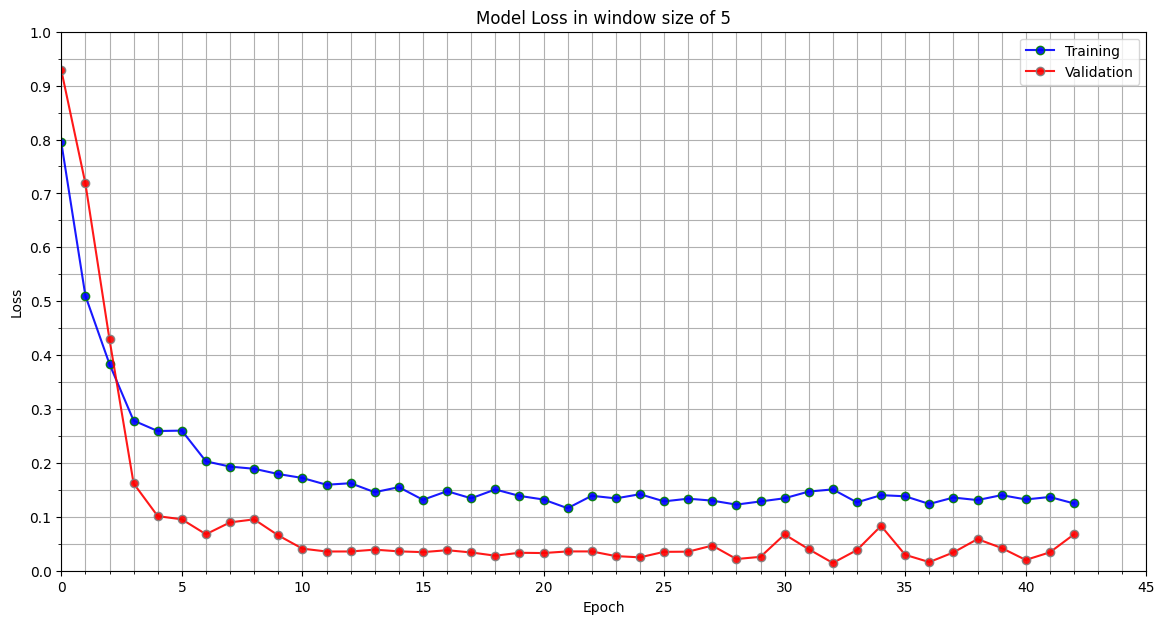

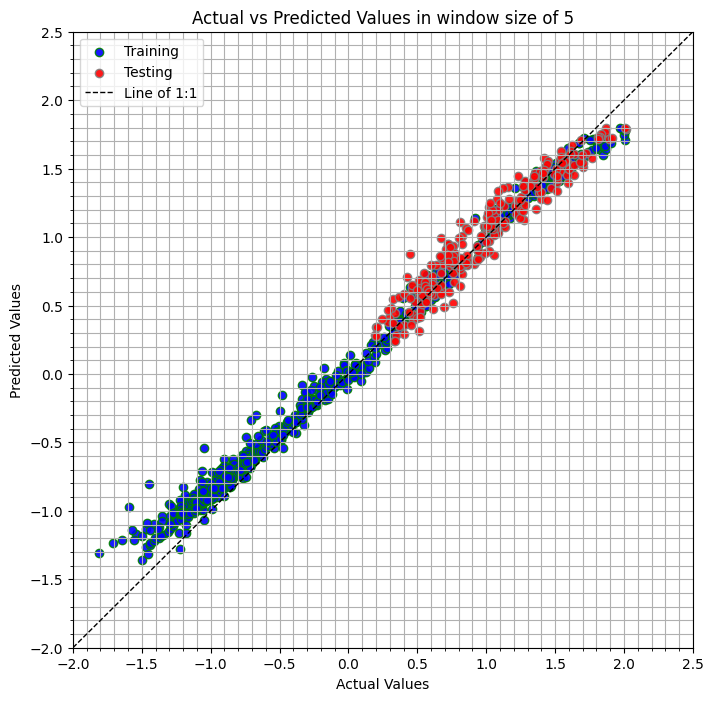

mse: 6431.694, rmse: 80.198, mae: 65.574, mape: 0.016, r2: 0.924 for window size 5
************************************************* End of Window Size: 5 *************************************************



************************************************* Start of Window Size: 10 *************************************************
csv of best hyperparameters record is found
window size of 10 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0131250573322176
Best Hyperparams: {'x0': 17, 'x1': 1, 'x2': 2, 'x3': 0, 'x4': 0, 'x5': 12, 'x6': 0.7, 'optimizer': 'RMSprop', 'learning_rate': 0.01} 

Iteration 1/10
Energy: 10.293269536664988
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (10, 1)
hyperparameters: {'x0': 18, 'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 9, 'x6': 0.6210275816746534, 'optimizer': 'RMSprop', 'learning_rate': 0.001}
Epoch 1/100
4/4 - 2s - loss: 0.9276 - val_loss: 1.0172 - 2s/epoch - 438ms/step
Epoch 

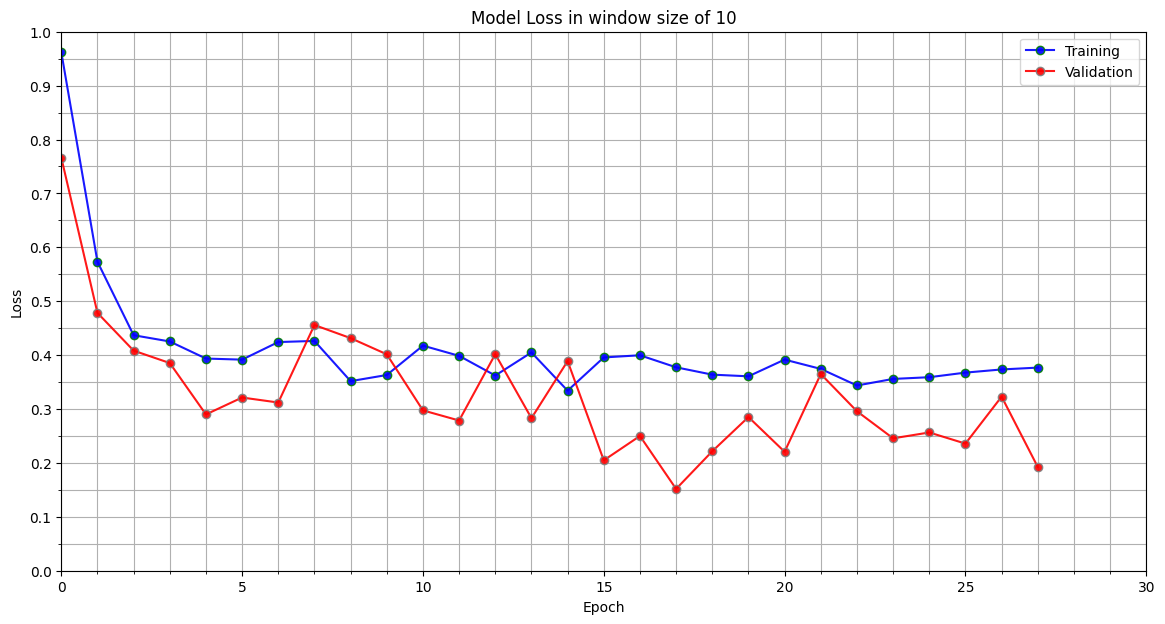

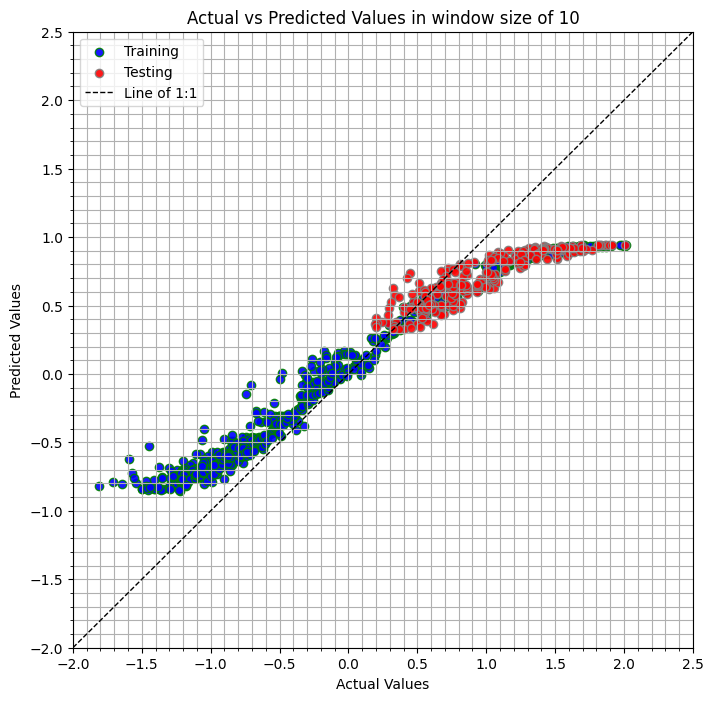

mse: 67855.923, rmse: 260.492, mae: 201.681, mape: 0.047, r2: 0.185 for window size 10
************************************************* End of Window Size: 10 *************************************************



************************************************* Start of Window Size: 30 *************************************************
csv of best hyperparameters record is found
window size of 30 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0089488411322236
Best Hyperparams: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 15, 'x6': 0.475998390958154, 'optimizer': 'Adam', 'learning_rate': 0.01} 

Iteration 1/10
Energy: 2.2185850893609897
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (30, 1)
hyperparameters: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 19, 'x6': 0.544676042710586, 'optimizer': 'Adam', 'learning_rate': 1e-06}
Epoch 1/100
4/4 - 1s - loss: 0.6877 - val_loss: 0.7885 - 1s/epoch - 287m

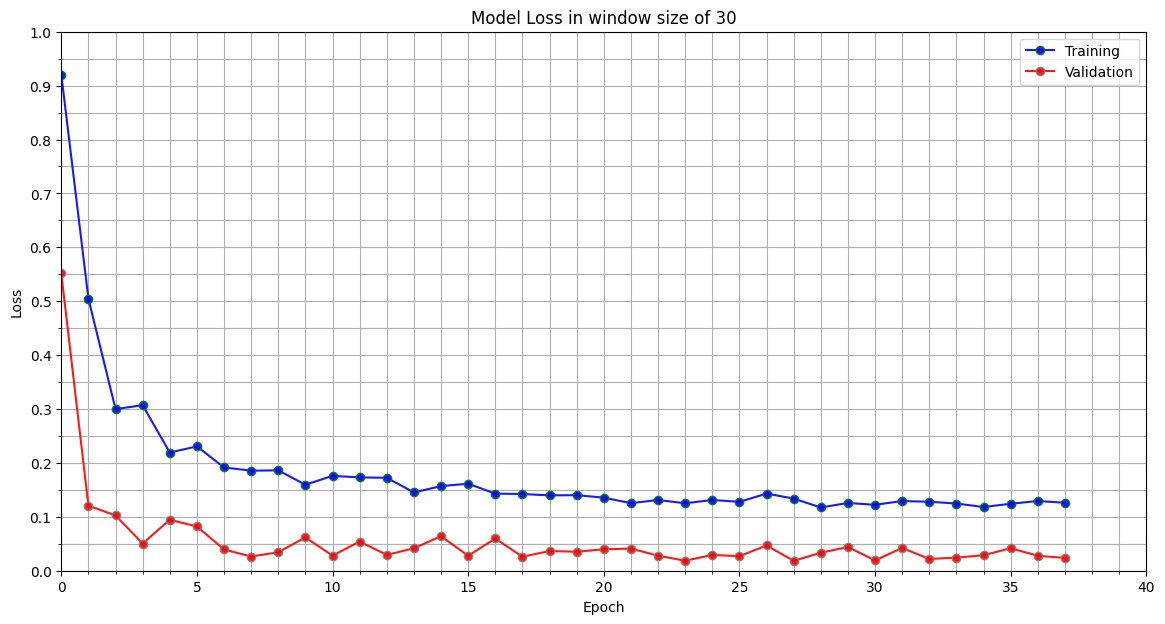

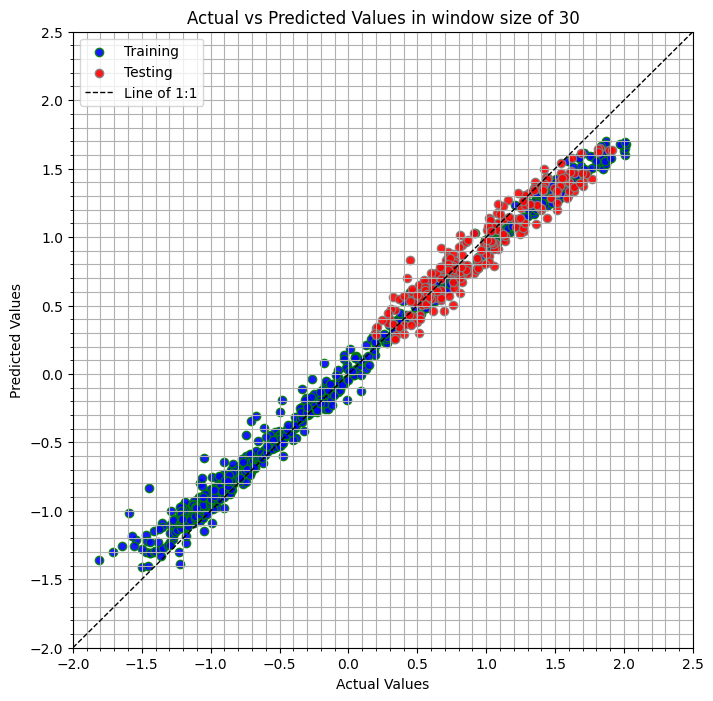

mse: 8194.579, rmse: 90.524, mae: 73.579, mape: 0.018, r2: 0.895 for window size 30
************************************************* End of Window Size: 30 *************************************************



************************************************* Start of Window Size: 60 *************************************************
csv of best hyperparameters record is found
window size of 60 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0196181740611791
Best Hyperparams: {'x0': 19, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 7, 'x6': 0.3, 'optimizer': 'SGD', 'learning_rate': 0.01} 

Iteration 1/10
Energy: 6.093624530954745
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (60, 1)
hyperparameters: {'x0': 20, 'x1': 1, 'x2': 4, 'x3': 0, 'x4': 0, 'x5': 5, 'x6': 0.3, 'optimizer': 'Adamax', 'learning_rate': 0.0001}
Epoch 1/100
4/4 - 2s - loss: 0.9450 - val_loss: 1.0334 - 2s/epoch - 444ms/step
Epoch 2/100
4/4 - 0s - lo

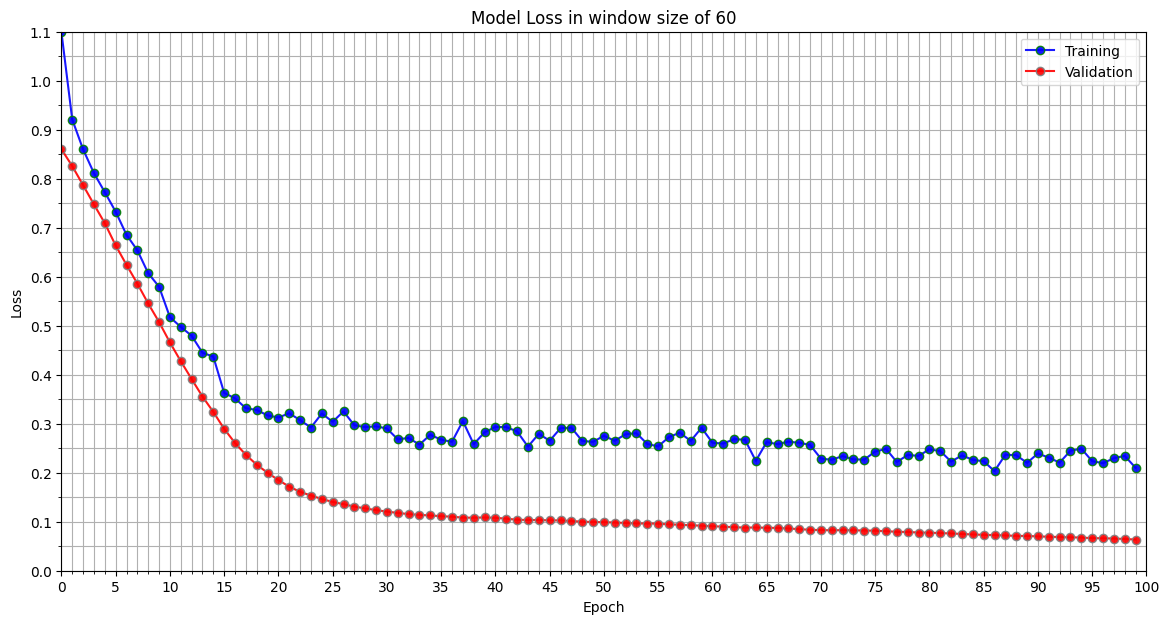

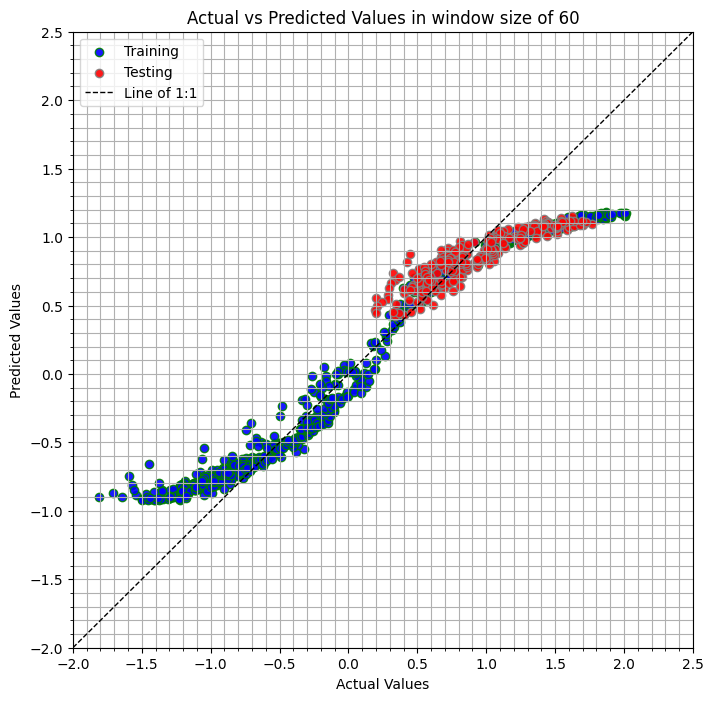

mse: 28443.934, rmse: 168.653, mae: 133.03, mape: 0.032, r2: 0.601 for window size 60
************************************************* End of Window Size: 60 *************************************************



************************************************* Start of Window Size: 120 *************************************************
csv of best hyperparameters record is found
window size of 120 is found
record window is DataFrame
non inf loss is found
Best Loss: 0.0098535679280757
Best Hyperparams: {'x0': 13, 'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 10, 'x6': 0.3, 'optimizer': 'RMSprop', 'learning_rate': 0.01} 

Iteration 1/10
Energy: 8.82982610364499
new hyperparams is mutated
below is the input shape and hyperparameters for the model
input shape:  (120, 1)
hyperparameters: {'x0': 13, 'x1': 1, 'x2': 1, 'x3': 1, 'x4': 4, 'x5': 5, 'x6': 0.3, 'optimizer': 'RMSprop', 'learning_rate': 1e-05}
Epoch 1/100
4/4 - 3s - loss: 1.1303 - val_loss: 1.0815 - 3s/epoch - 727ms/step
Epoch 2/100
4/4 

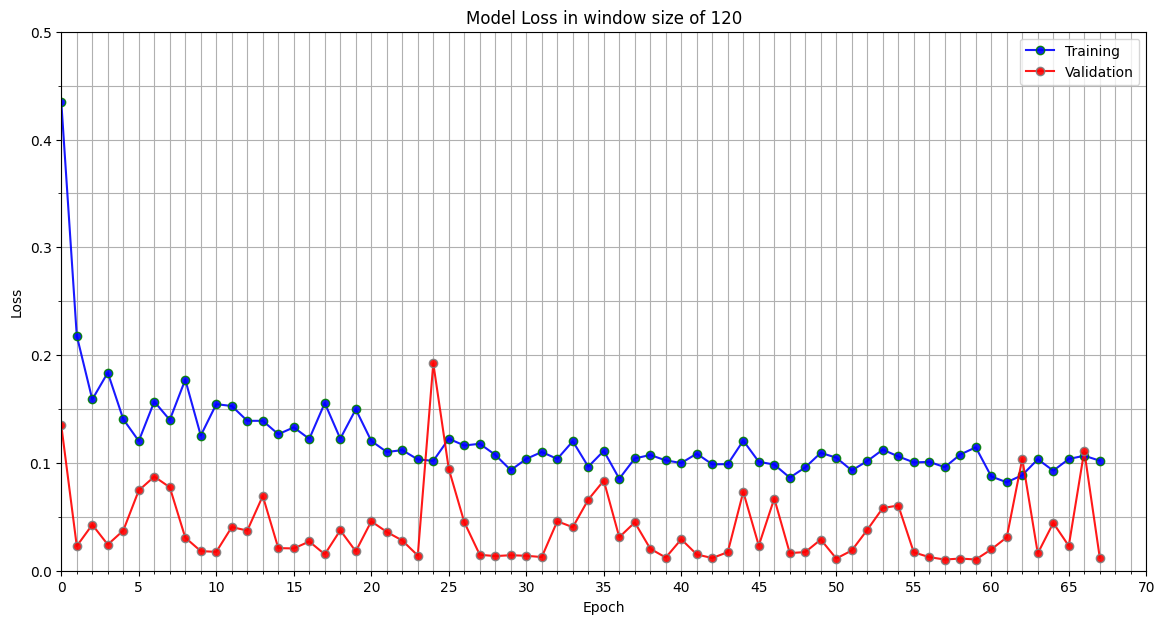

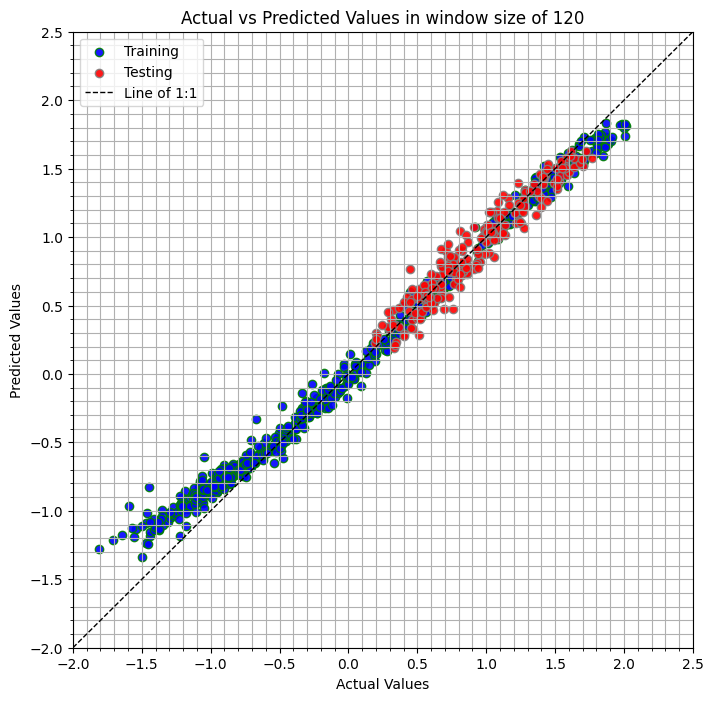

mse: 4640.7, rmse: 68.123, mae: 55.885, mape: 0.014, r2: 0.93 for window size 120
************************************************* End of Window Size: 120 *************************************************



All models are trained and evaluated


In [18]:
if __name__ == "__main__":

    ticker="^GSPC"
    start_date="2018-01-01"
    end_date="2023-01-01"
    window_size_list=[5, 10, 30, 60, 120]
    max_iter=10
    population_size=10

    dict_model, dict_history, dict_result, dict_performace_metrix, dict_best_params, dict_best_loss = main_program(
        ticker, start_date, end_date, window_size_list, max_iter, population_size)

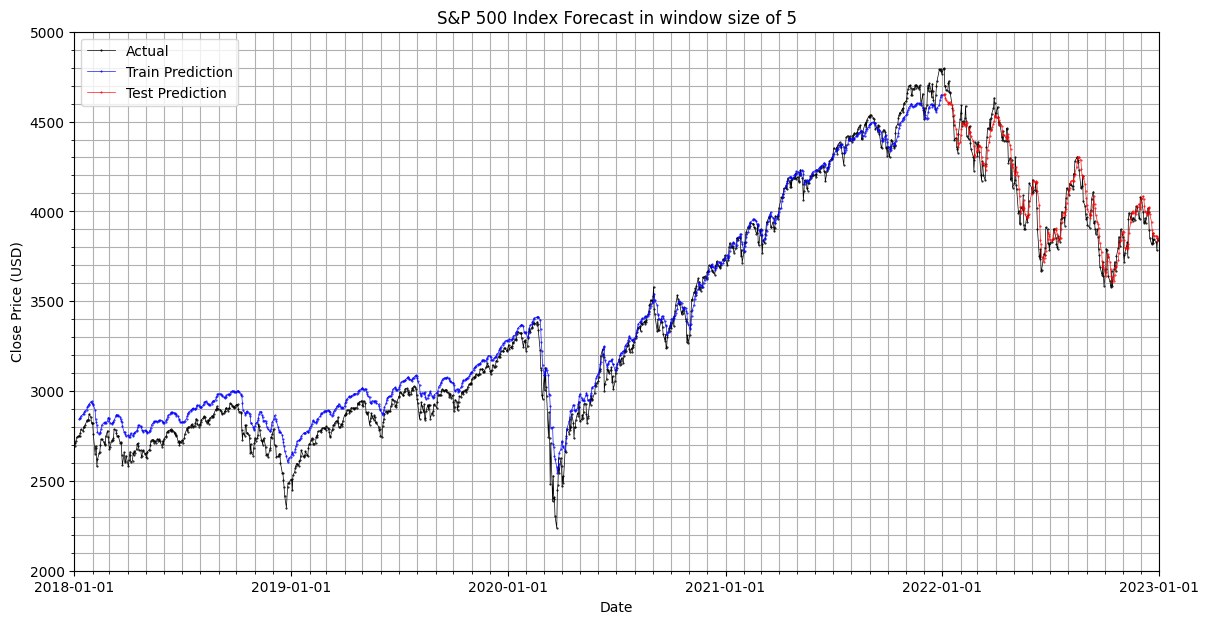

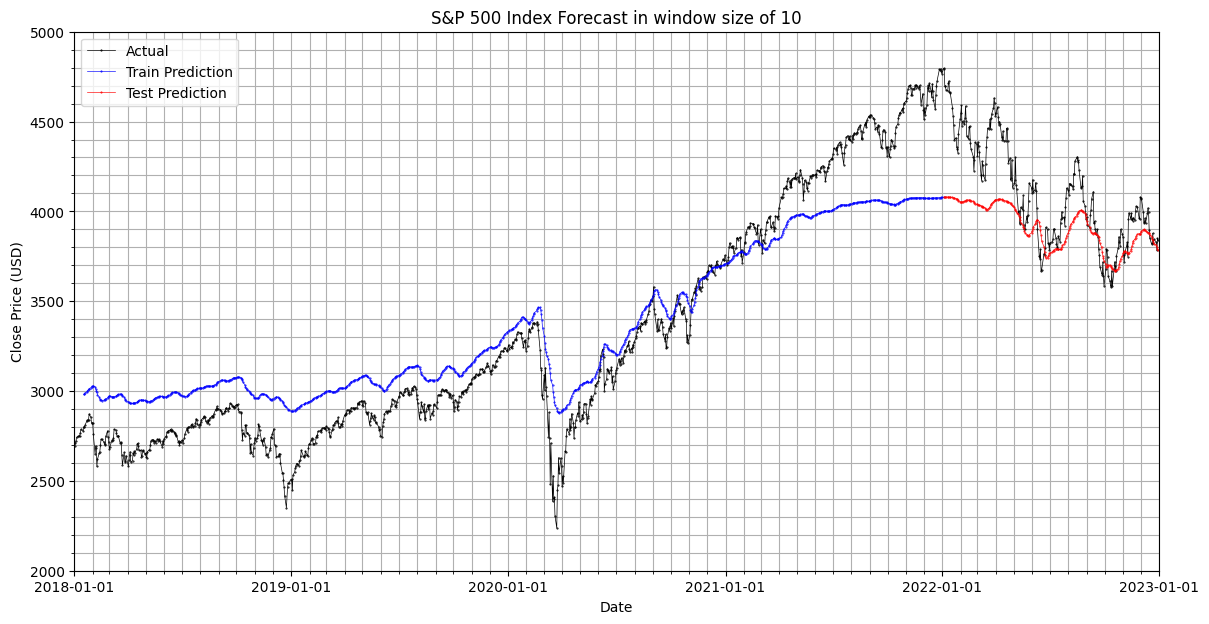

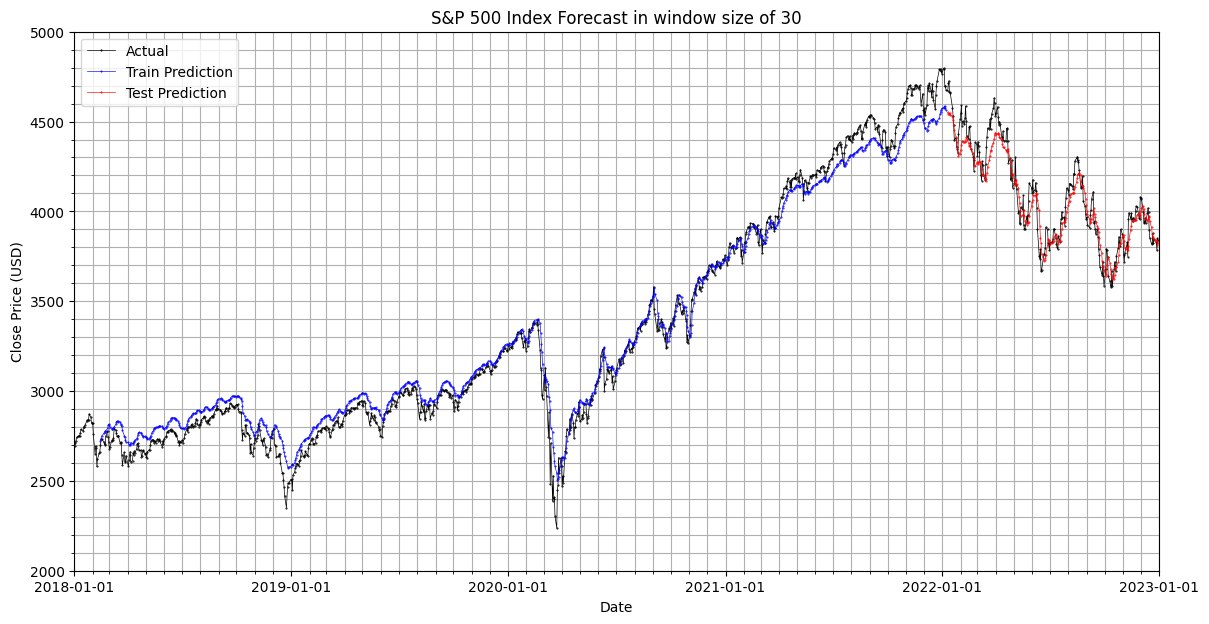

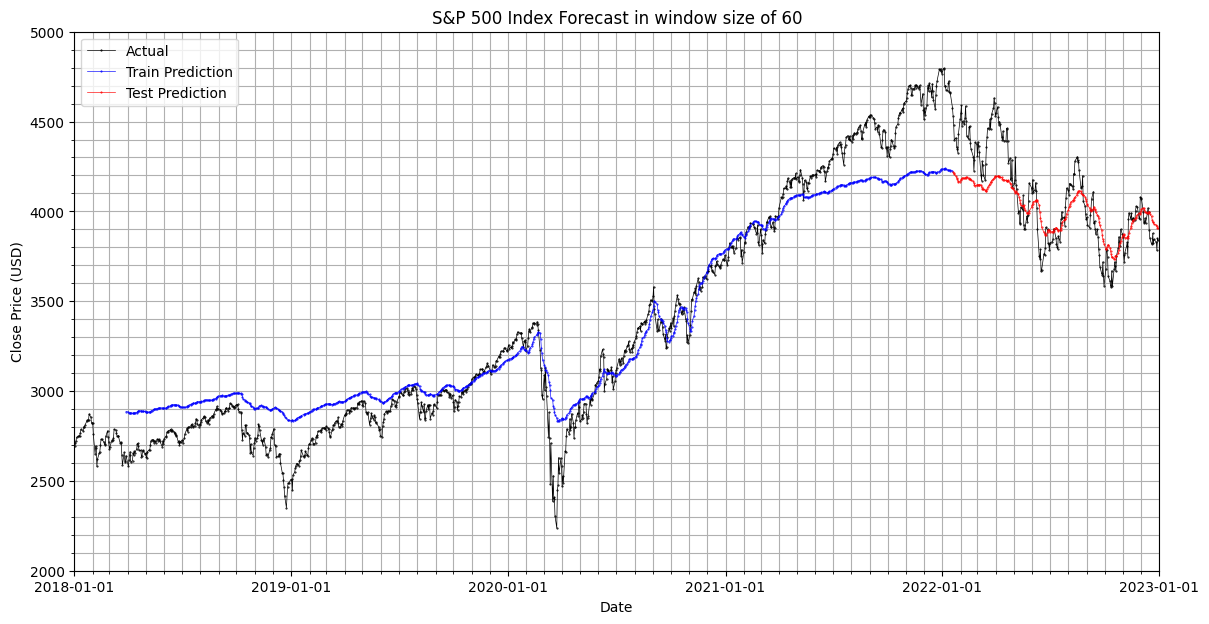

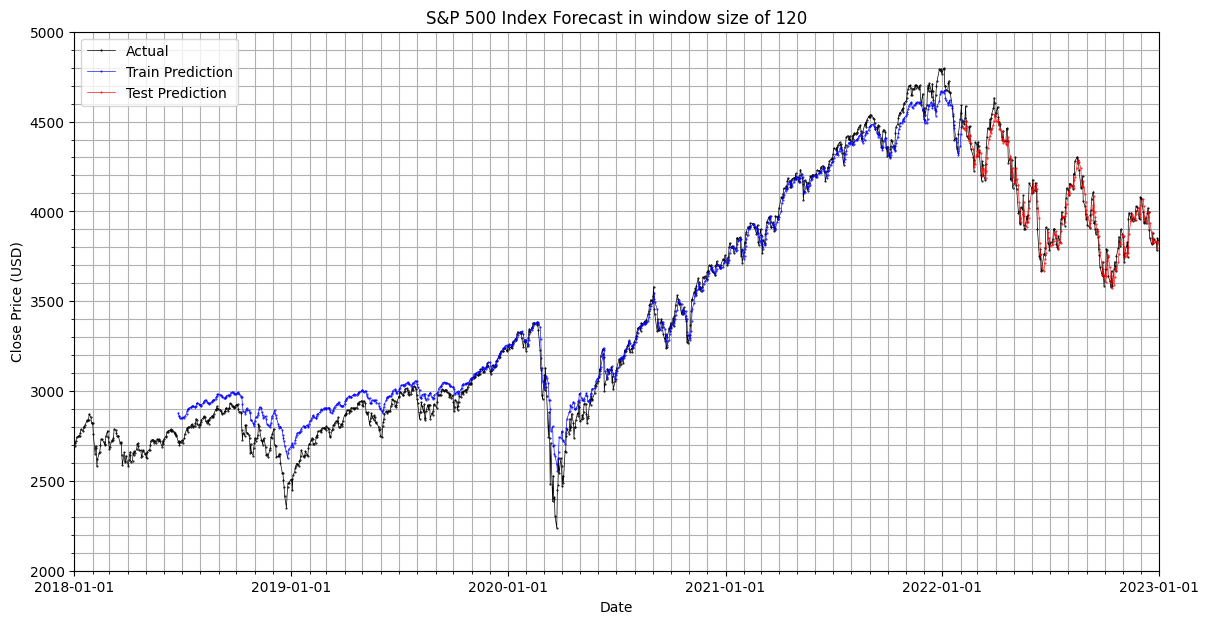

In [19]:
# plot the results
for window_size, df_results in dict_result.items():
    fig, ax = plot_results(df_results, start_date, end_date, window_size)
#     fig.savefig(f"results_{window_size}.png")

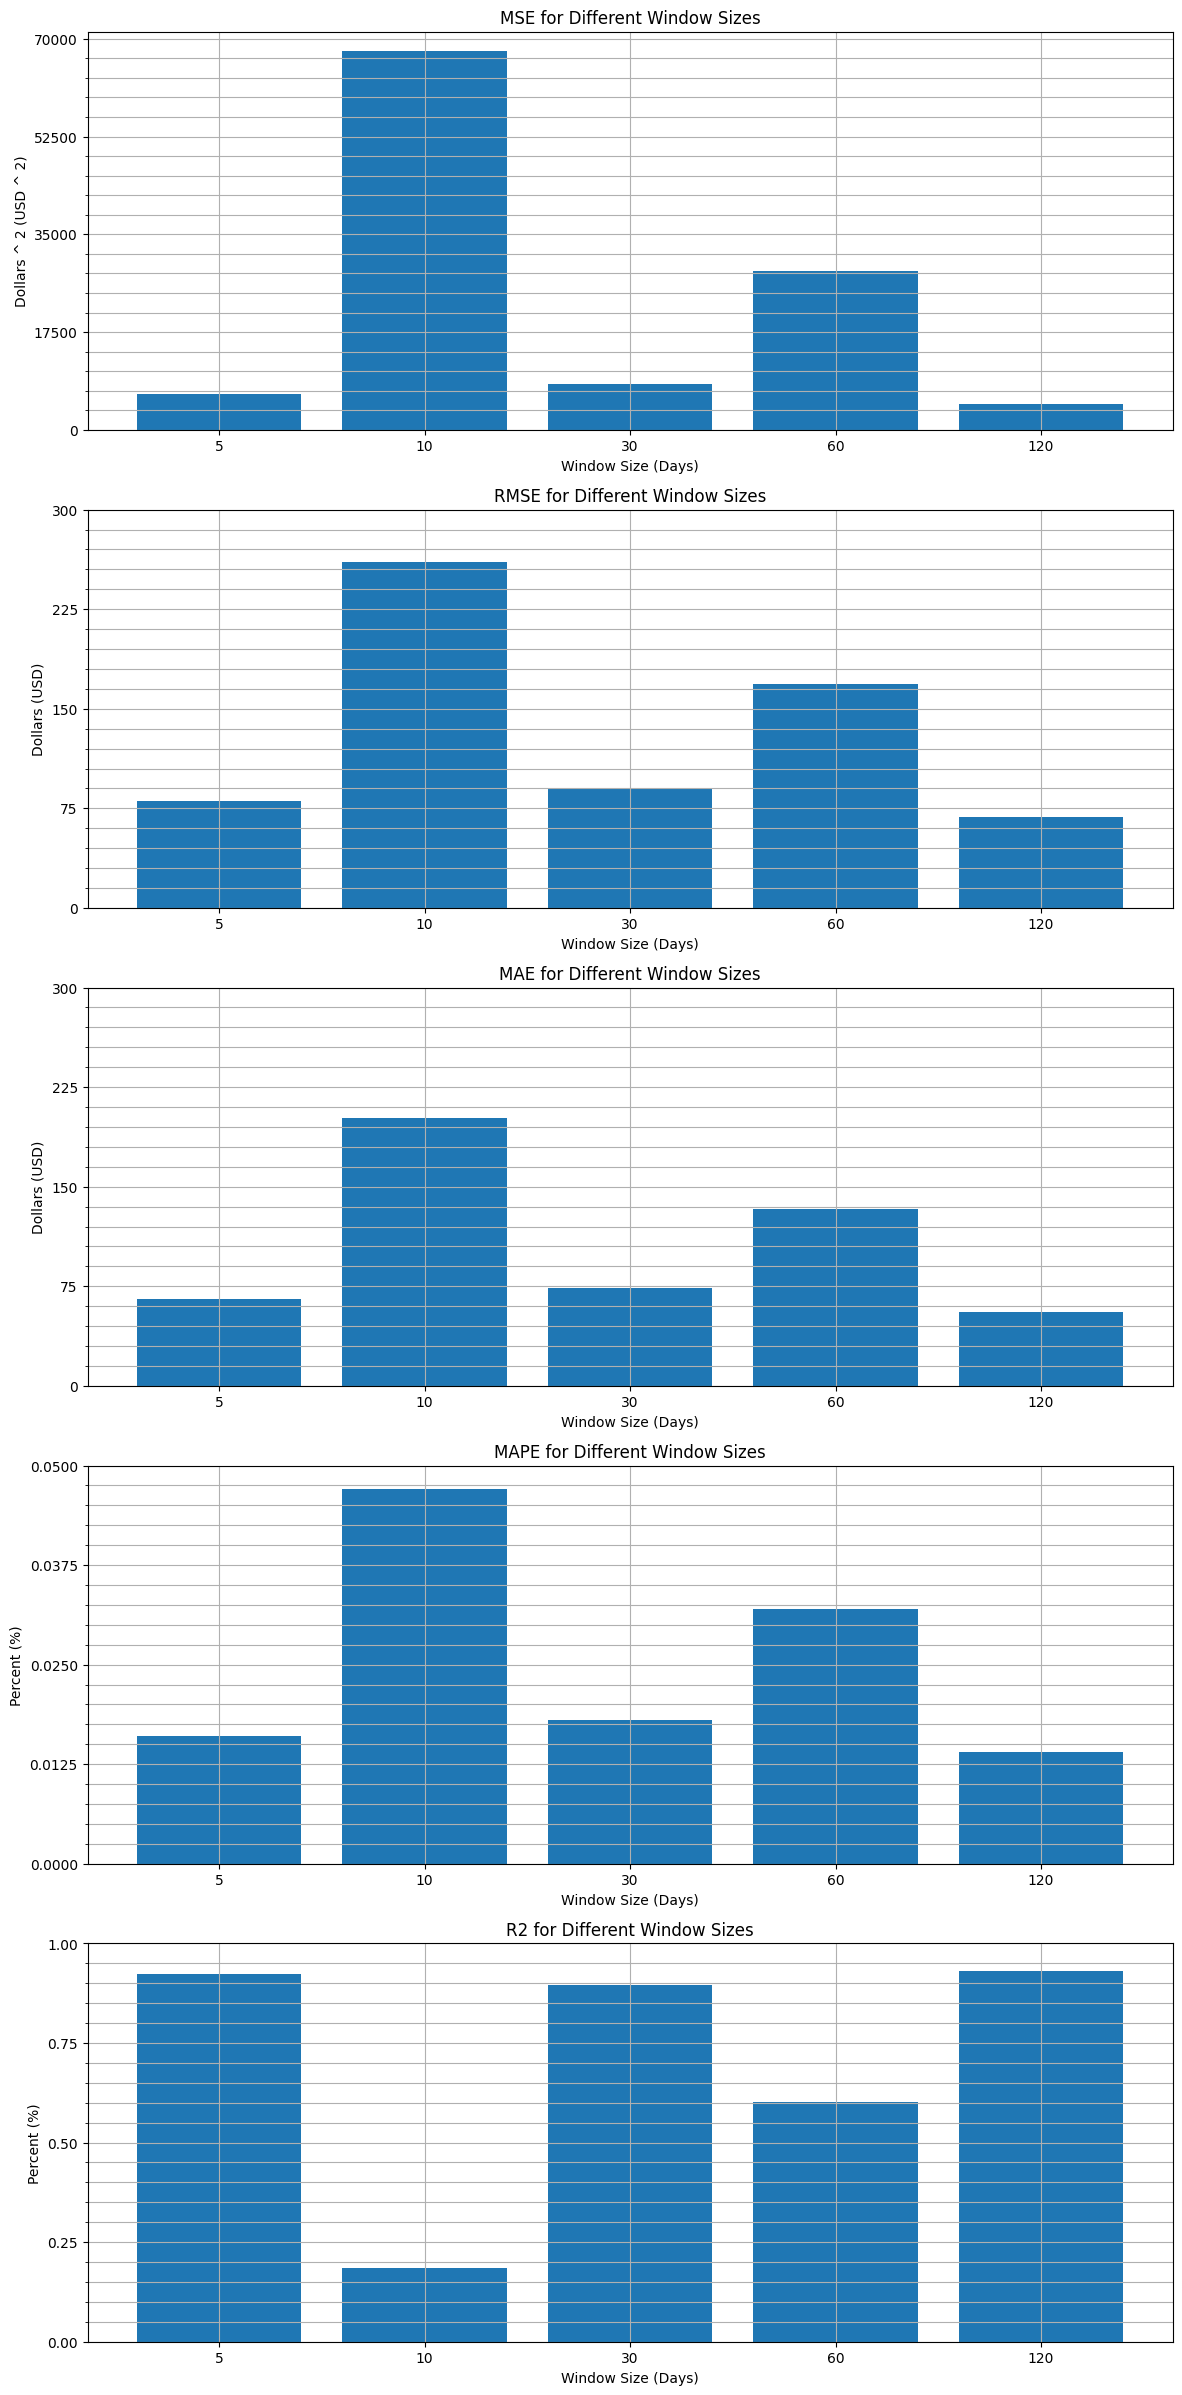

In [20]:
plot_performace_metrix(dict_performace_metrix)

In [21]:
pd.read_csv('best_hyperparameters_record.csv', index_col=0, parse_dates=['time_stamp']).tail(10)

best_loss  x0  x1  x2  x3  x4  x5        x6 optimizer  learning_rate  \
5     0.010645   7   0   0   0   0  16  0.459436      Adam           0.01   
10    0.013125  17   1   2   0   0  12  0.700000   RMSprop           0.01   
30    0.008949  13   0   0   0   0  15  0.475998      Adam           0.01   
60    0.019618  19   0   0   0   0   7  0.300000       SGD           0.01   
120   0.009854  13   0   0   0   0  10  0.300000   RMSprop           0.01   
5     0.010645   7   0   0   0   0  16  0.459436      Adam           0.01   
10    0.013125  17   1   2   0   0  12  0.700000   RMSprop           0.01   
30    0.008949  13   0   0   0   0  15  0.475998      Adam           0.01   
60    0.019618  19   0   0   0   0   7  0.300000       SGD           0.01   
120   0.009854  13   0   0   0   0  10  0.300000   RMSprop           0.01   

                    time_stamp  
5   2025-03-24 14:52:42.214049  
10  2025-03-24 14:52:42.214049  
30  2025-03-24 14:52:42.214049  
60  2025-03-24 14:52:42.214049  
120 2025-03-24 14:52:42.214049  
5   2025-03-24 15:48:11.224947  
10  2025-03-24 15:48:11.224947  
30  2025-03-24 15:48:11.224947  
60  2025-03-24 15:48:11.224947  
120 2025-03-24 15:48:11.224947